In [1]:
class Timeline:

    def __init__(self) -> None:
        self.actions = []
        self.actions.append(Timeline.Action(0, "None"))
        self.lastTimeStep = 0
        pass

    def process_actions(self):
        """Process the actions in the timeline. If an action appears several times in 10 seconds, they will be merged. An action should be deleted if it last less than 1 second after the merge. If several different types of action overlap, the overlapping part will be deleted for the one starting last until there is no overlapping left.
        """
        for i in range(len(self.actions)):
            if not self.actions[i].processed:
                next = i
                break
        
        # Merge actions
        while next < len(self.actions):
            if not self.actions[next].processed:
                self.actions[next].processed = True
                i = next+1
                while i < len(self.actions):
                    if self.actions[i].type_action == self.actions[next].type_action:
                        if self.actions[i].start - self.actions[next].end <= 10000: # 10 seconds in milliseconds
                            self.actions[next].end = self.actions[i].end
                            self.actions.pop(i)
                            i-=1
                        else:
                            break
                    i += 1

                if self.actions[next].end - self.actions[next].start < 1000: # 1 second in milliseconds
                    self.actions.pop(next)
                else:
                    next += 1
            else:
                next += 1
        
        # print all actions
        for i in range(len(self.actions)):
            print(self.actions[i].start, self.actions[i].end, self.actions[i].type_action)
        
        # Delete overlapping actions
        i = 0
        while i < len(self.actions):
            if not self.actions[i].processed:
                raise Exception("Action not processed")
            j = i+1
            while j < len(self.actions):
                if self.actions[i].end > self.actions[j].start:
                    self.actions[i].end = self.actions[j].start
                j += 1
            i += 1
        
        # Add action NoClass when there is no action
        i = 0
        while i < len(self.actions):
            if i == 0:
                if self.actions[i].start != 0:
                    self.actions.insert(0, Timeline.Action(0, "NoClass"))
                    self.actions[0].end = self.actions[1].start
                    i += 1
            else:
                if self.actions[i].start - self.actions[i-1].end > 0:
                    self.actions.insert(i, Timeline.Action(self.actions[i-1].end, "NoClass"))
                    self.actions[i].end = self.actions[i+1].start
                    i += 1
            i += 1
        if self.actions[-1].end != self.lastTimeStep:
            self.actions.append(Timeline.Action(self.actions[-1].end, "NoClass"))
            self.actions[-1].end = self.lastTimeStep
                

    def updateTimeline(self, time_action: int, type_action: str):
        """
        Update the timeline with the action and the time of the action. The time must always be greater than the one from the last call of the method.

        Args:
            time_action (int): The time of the action
            type_action (str): The class of the action
        """
        prev = self.actions[-1]
        if prev.getTypeAction() != type_action:
            self.actions.append(Timeline.Action(time_action, type_action))
        else:
            prev.update(time_action)
        self.lastTimeStep = time_action
    
    class Action:
        """
        Class that represents an action in the timeline
        """

        def __init__(self, time_action_begin: int, type_action: str) -> None:
            """
            Constructor of the class

            Args:
                time_action_begin (int): The start of the action
                time_action_end (int): The end of the action
                type_action (str): The class of the action
            """
            self.start = time_action_begin
            self.end = time_action_begin
            self.type_action = type_action
            self.processed = False
        
        def update(self, end_time) -> None:
            self.end = end_time

        def getTimeAction(self) -> tuple:
            """
            Get the time of the action

            Returns:
                int: The time of the action
            """
            return self.start, self.end

        def getTypeAction(self) -> str:
            """
            Get the class of the action

            Returns:
                str: The class of the action
            """
            return self.type_action

In [2]:
import sqlite3 as sql
import cv2
import statistics
import tensorflow as tf
from tqdm import tqdm
import numpy as np

2023-02-23 15:13:10.861437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
mod = tf.keras.models.load_model('/home/mdelabrassinne/DSproject/classification_images/model_v0.h5')
mod.summary()

2023-02-23 15:13:31.252784: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-23 15:13:31.254466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-23 15:13:31.322883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:40:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-02-23 15:13:31.322931: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-23 15:13:31.577382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-23 15:13:31.577496: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                12616736  
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1

In [4]:
FPS = 25
NOTHING = 0
CORNER = 1
hPixel = 224
wPixel = 224
window_size = 25

In [5]:
db_path = "/scratch/users/mdelabrassinne/Database/SoccerDB.db"

In [6]:
con = sql.connect(db_path)
curs = con.cursor()
curs.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(curs.fetchall())

[('VIDEO',), ('Sequence',), ('IMAGE',)]


In [7]:
curs.execute("SELECT StartTime,Label FROM Sequence  WHERE VideoPath = '/scratch/users/mdelabrassinne/Database/england_epl/2014-2015/2015-02-21_-_18-00_Chelsea_1_-_1_Burnley/1_224p.mkv'")
print(curs.fetchall())

[]


In [8]:
curs.execute

<function Cursor.execute>

In [9]:
def predict_on_matches(model, db, window_size, video = None, test_set = True):
    predictions = []
    if test_set:
        set_name = "test"
    else:
        set_name = "validation"
    con = sql.connect(db)
    cur = con.cursor()
    test_videos = cur.execute("SELECT Path_video FROM VIDEO WHERE Path_video LIKE '%italy_serie-a%' OR Path_video LIKE '%spain_laliga%'")

    for video in test_videos:
        predictions.append(predict_match(model,video,window_size))

    return predictions

In [10]:
def image_classification(image,model):
    new_image = cv2.resize(image, (hPixel,wPixel))
    X = [new_image]
    X = np.array(X).reshape(-1,224,224,3)
    pred = model.predict(X)
    if pred < 0.5:
        return "Corner"
    return "NoClass"

In [11]:
def predict_match(model,video, window_size):
    current_window = []
    match_predictions_window = []
    cap = cv2.VideoCapture(video[0])
    success, image = cap.read()
    indicator = 0
    while success:
        indicator += 1
        current_window.append(image_classification(image,model))
        if len(current_window) >= window_size:
            current_window.pop(0)
            if indicator%(60*25) == 0:
                print(indicator/(25*60),statistics.mode(current_window))
            match_predictions_window.append(statistics.mode(current_window))
        success, image = cap.read()
    cap.release()
    return match_predictions_window

In [12]:
def predict_on_matches(test_videos,model,window_size):
    predictions = []
    for video in test_videos:
        predictions.append(predict_match(model,video,window_size))
    return predictions

In [13]:
def evaluation(model, db, window_size, Q, video = None, test_set = True):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    if test_set:
        set_name = "test"
    else:
        set_name = "validation"
    con = sql.connect(db)
    cur = con.cursor()
    #test_videos = cur.execute("SELECT Path_video FROM VIDEO WHERE (Path_video LIKE '%italy_serie-a%' OR Path_video LIKE '%spain_laliga%') AND (Path_video LIKE '%1_224p.mkv%')")
    test_videos = cur.execute("SELECT Path_video FROM VIDEO WHERE Path_video LIKE '%2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna%' AND Path_video LIKE '%1_224p.mkv%'")
    testing = test_videos.fetchall()
    predictions = predict_on_matches(testing,model,window_size)
    for video,pred_vect in zip(testing,predictions):
        video = video[0]
        print(video)
        print(pred_vect)
        match_sequences = con.cursor().execute("SELECT StartTime,Label FROM Sequence WHERE VideoPath='"+video+"' AND Label='Corner'").fetchall()
        print(match_sequences)
        match_timeline = Timeline()
        time = 1
        for pred_frame in pred_vect:
            match_timeline.updateTimeline(time/FPS*1000,pred_frame)
            time += 1

        match_timeline.process_actions()
        (current_event_time,current_event_label) = match_sequences.pop(0)
        for action in match_timeline.actions:
            if current_event_time - Q > action.getTimeAction()[0] and action.getTypeAction() != "NoClass":
                FP += 1
            elif current_event_time - Q >= action.getTimeAction()[0] and action.getTypeAction() == "NoClass":
                TN += 1
            elif current_event_time - Q <= action.getTimeAction()[0] and current_event_time + Q >= action.getTimeAction()[0]:
                if action.getTypeAction() == current_event_label:
                    TP += 1
                    (current_event_time,current_event_label) = match_sequences.pop(0)
                else:
                    FN += 1
            else:
                while current_event_time + Q < action.getTimeAction()[0]:
                    (next_event_time,next_event_label) = match_sequences.pop(0)
                    if next_event_time < current_event_time:
                        return([[TP,FN],[FP,TP]])
                    (current_event_time,current_event_label) = (next_event_time,next_event_label)
    return([[TP,FN],[FP,TP]],predictions[0])

In [14]:
mod.save('mod_eval1.h5')

In [ ]:
eval_metrics = evaluation(mod,db_path,window_size, 10000)

In [16]:
con = sql.connect(db_path)
cur = con.cursor()
#test_videos = cur.execute("SELECT Path_video FROM VIDEO WHERE (Path_video LIKE '%italy_serie-a%' OR Path_video LIKE '%spain_laliga%') AND (Path_video LIKE '%1_224p.mkv%')")
test_videos = cur.execute("SELECT Path_video FROM VIDEO WHERE Path_video LIKE '%2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna%' AND Path_video LIKE '%1_224p.mkv%'")
testing = test_videos.fetchall()
predictions = predict_on_matches(testing,mod,window_size)

1.0 NoClass
2.0 NoClass
3.0 NoClass
4.0 NoClass
5.0 NoClass
6.0 NoClass
7.0 Corner
8.0 NoClass
9.0 NoClass
10.0 NoClass
11.0 NoClass
12.0 NoClass
13.0 NoClass
14.0 NoClass
15.0 NoClass
16.0 NoClass
17.0 NoClass
18.0 NoClass
19.0 NoClass
20.0 NoClass
21.0 NoClass
22.0 NoClass
23.0 NoClass
24.0 NoClass
25.0 NoClass
26.0 NoClass
27.0 NoClass
28.0 NoClass
29.0 NoClass
30.0 NoClass
31.0 NoClass
32.0 NoClass
33.0 NoClass
34.0 NoClass
35.0 NoClass
36.0 Corner
37.0 NoClass
38.0 NoClass
39.0 NoClass
40.0 Corner
41.0 NoClass
42.0 NoClass
43.0 NoClass
44.0 NoClass
45.0 NoClass


In [29]:
print(predictions[0])
values = ['1', '2', '3']

with open("file.txt", "w") as output:
    output.write(str(predictions[0]))

['NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass', 'NoClass'

In [45]:
match_sequences = cur.execute("SELECT StartTime,Label,VideoPath FROM Sequence WHERE VideoPath LIKE '%2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna%' AND VideoPath LIKE '%1_224p.mkv%' AND Label = 'Corner'")
print(list(match_sequences))

[(101, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_laliga/2014-2015/2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna/sequences/1_224p.mkv'), (344, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_laliga/2014-2015/2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna/sequences/1_224p.mkv'), (683, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_laliga/2014-2015/2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna/sequences/1_224p.mkv'), (788, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_laliga/2014-2015/2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna/sequences/1_224p.mkv'), (885, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_laliga/2014-2015/2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna/sequences/1_224p.mkv'), (1215, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_laliga/2014-2015/2015-02-14_-_20-00_Real_Madrid_2_-_0_Dep._La_Coruna/sequences/1_224p.mkv'), (1742, 'Corner', '/scratch/users/mdelabrassinne/Database/spain_lalig

In [67]:
timeline = Timeline()
time = 0
for pred in predictions[0]:
    timeline.updateTimeline(time/25*1000,pred)
    time += 1
    
timeline.process_actions()

0.0 2721040.0 NoClass
75800.0 96880.0 Corner
109480.0 112560.0 Corner
215160.0 218760.0 Corner
243120.0 245160.0 Corner
284120.0 287640.0 Corner
300880.0 312840.0 Corner
329520.0 345600.0 Corner
371560.0 381960.0 Corner
394600.0 407680.0 Corner
418320.0 436840.0 Corner
516240.0 518960.00000000006 Corner
576680.0 602400.0 Corner
639600.0 643080.0 Corner
680840.0 683560.0 Corner
728000.0 754280.0 Corner
770760.0 783000.0 Corner
808320.0 828720.0 Corner
841800.0 843000.0 Corner
859600.0 897800.0 Corner
981440.0 996320.0 Corner
1062920.0 1064680.0 Corner
1084480.0 1106320.0 Corner
1204720.0 1212680.0 Corner
1234480.0 1247920.0 Corner
1270040.0 1275640.0 Corner
1325680.0 1345800.0 Corner
1357000.0 1382560.0 Corner
1428720.0 1449240.0 Corner
1462600.0 1485480.0 Corner
1496520.0 1508200.0 Corner
1682800.0 1700840.0 Corner
1719040.0 1735720.0 Corner
1754920.0 1770040.0 Corner
1798120.0 1800680.0 Corner
1813080.0 1824720.0 Corner
1853120.0 1873920.0 Corner
1920640.0 1922520.0 Corner
1947160.0 1

In [50]:
match_sequences = [101,344,683,788,885,1215,788,885,1215,1742,2556,2626]
match_timeline = [0]*len(binary_pred)
for i in match_sequences:
    match_timeline[i*25] = 1
print(match_timeline)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

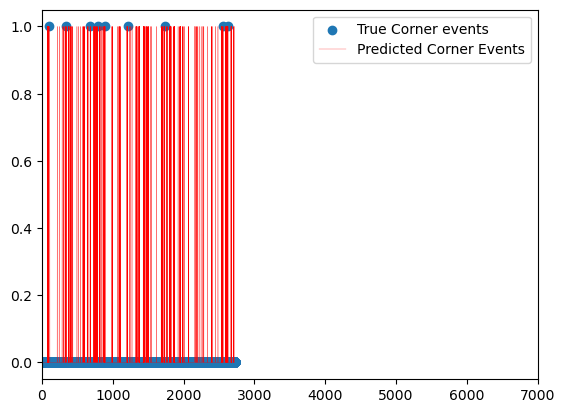

In [119]:
import matplotlib.pyplot as plt

plt.scatter([i / 25 for i in range(len(match_timeline))],match_timeline, label = "True Corner events")
plt.plot([i / 25 for i in range(len(match_timeline))],binary_pred, c = 'r', linewidth = 0.2, label = "Predicted Corner Events")
plt.xlim([0,7000])
plt.legend()
plt.show()

In [59]:
binary_pred = []
for pred in predictions[0]:
    if pred == 'NoClass':
        binary_pred.append(0)
    elif pred == 'Corner':
        binary_pred.append(1)
print(binary_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [111]:
FP = 0
FN = 0
TP = 0
TN = 0
Q = 10000

match_sequences2 = [1000*i for i in match_sequences]
match_sequences_ev = ['Corner']*len(match_sequences2)
match_sequences2 = [(i,j) for i in match_sequences2 for j in match_sequences_ev]
(current_event_time,current_event_label) = match_sequences2.pop(0)
for action in timeline.actions:
    if current_event_time - Q > action.getTimeAction()[1] and action.getTypeAction() != "NoClass":
        FP += 1
    elif current_event_time - Q >= action.getTimeAction()[1] and action.getTypeAction() == "NoClass":
        TN += 1
    elif current_event_time - Q <= action.getTimeAction()[1] and current_event_time + Q >= action.getTimeAction()[1]:
        if action.getTypeAction() == current_event_label:
            TP += 1
            (current_event_time,current_event_label) = match_sequences2.pop(0)
        else:
            FN += 1
    else:
        while current_event_time + Q < action.getTimeAction()[0]:
            (next_event_time,next_event_label) = match_sequences2.pop(0)
            (current_event_time,current_event_label) = (next_event_time,next_event_label)


IndexError: pop from empty list

In [104]:
TP = 0
TN = 0
FP = 0
FN = 0
match_sequences2 = [1000*i for i in match_sequences]
match_sequences_ev = ['Corner']*len(match_sequences2)
match_sequences2 = [(i,j) for i in match_sequences2 for j in match_sequences_ev]
for current_event_time,current_event_label in match_sequences2:
    for action in timeline.actions:
        if current_event_time - Q > action.getTimeAction()[1] and action.getTypeAction() != "NoClass":
            FP += 1
        elif current_event_time - Q >= action.getTimeAction()[1] and action.getTypeAction() == "NoClass":
            TN += 1
        elif current_event_time - Q <= action.getTimeAction()[0] and current_event_time + Q >= action.getTimeAction()[0]:
            if action.getTypeAction() == current_event_label:
                TP += 1
                (current_event_time,current_event_label) = match_sequences2.pop(0)
            else:
                FN += 1

In [115]:
print(FN)

2


In [46]:
print(list(match_sequences))

[]
